<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/2021_12_01_geometry_mbilynsky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import site
import sys


try : 
    from google.colab import files
except:
    pass
    
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y fenics    
    site.addsitedir('/usr/lib/petsc/lib/python3/dist-packages')  # Always appends to end

    from fenics import *; from mshr import *
    from ufl import replace

!fenics-version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
software-properties-common is already the newest version (0.96.24.32.14).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]


In [ ]:
import matplotlib.pyplot as plt;
import numpy as np;
import math;
from IPython.display import clear_output, display, update_display; import time; 
# import dolfin.common.plotting as fenicsplot 
import time
%matplotlib inline
plt.rcParams['image.cmap'] = 'viridis'

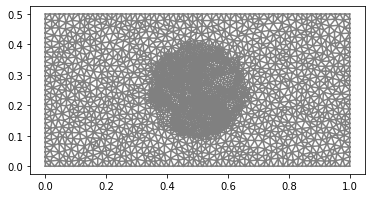

In [ ]:
Ly = 1.; Lx = .5
a = .2
crack_thick = 0.0005
cut_out_point_1 = (L/2 - crack_thick/2,  H/2 - a/2)
cut_out_point_2 = (L/2 + crack_thick/2,  H/2 + a/2)
mid_point = (L/2, H/2)
theta = math.pi/180*45
cell_size = 0.03
nel = int(L/cell_size)


geom1 = Rectangle(Point(0., 0.), Point(Lx, Ly))
cut_out = Rectangle(Point(cut_out_point_1), Point(cut_out_point_2))
geom = geom1 - CSGRotation(cut_out, Point(mid_point), theta)
mesh = generate_mesh(geom, nel)
ndim = mesh.topology().dim()
cell_mrk = MeshFunction('bool', mesh, ndim); cell_mrk.set_all(False)
for cell in cells(mesh):
 distance = (mid_point[0] - cell.midpoint()[0], mid_point[1] - cell.midpoint()[1])
 d = sqrt((distance[0]**2) + (distance[1]**2))
 if d < 0.15:
  cell_mrk[cell] = True
meshFine = refine(mesh, cell_mrk)
plot(meshFine)

In [ ]:
left = CompiledSubDomain('near(x[0], 0, 1e-4)')
right = CompiledSubDomain('near(x[0], {}, 1e-4)'.format(L))

boundaries = MeshFunction('size_t', mesh, 1)
boundaries.set_all(0)

left.mark(boundaries, 1) # mark left as 1
right.mark(boundaries,2) # mark right as 2
ds = Measure('ds', subdomain_data=boundaries) # surface measures ds(1), ds(2)

In [ ]:
# Constitutive functions

E, nu = Constant(1.), Constant(.3)
Gc = Constant(1.)
ell = Constant(0.1)


# w(a), 

def w(alpha):
  return alpha

def a(alpha):
  return (1-alpha)**2

def eps(u):
  return sym(grad(u))

def sigma0(u):
  mu = E/(2.*(1.+nu))
  lmbda = E*nu/(1-nu**2.)
  return 2*mu*eps(u) + lmbda*tr(eps(u))*Identity(ndim)

def sigma(alpha, u):
  return a(alpha)*sigma0(u)

In [ ]:
V_u = VectorFunctionSpace(mesh, 'P', 1)
V_alpha = FunctionSpace(mesh, 'P', 1)

u = Function(V_u)
du = TrialFunction(V_u)
v = TestFunction(V_u)
alpha = Function(V_alpha)
beta = TestFunction(V_alpha)
dalpha = TrialFunction(V_alpha)


In [ ]:
cw = 8/3

elastic_energy = 0.5*inner(sigma(alpha, u), eps(u))*dx
dissipated_energy = Gc/cw * (w(alpha)/ell + ell* inner(grad(alpha), grad(alpha)))*dx


total_energy = elastic_energy + dissipated_energy 

E_u = derivative(total_energy, u, v)

from ufl import replace
E_du = replace(E_u, {u: du})

E_alpha = derivative(total_energy, alpha, beta)
E_alpha_alpha = derivative(E_alpha,alpha, dalpha)
A = inner(sigma(alpha, du), eps(u))*dx

In [ ]:
u_R = Expression(('t', 0), t=0., degree=0)

bcu_0 = DirichletBC(V_u, u_R, boundaries, 2)
bcu_1 = DirichletBC(V_u, Constant((0., 0.)), boundaries, 1)
bc_u = [bcu_0, bcu_1]


bca_0 = DirichletBC(V_alpha, Constant(0.), boundaries, 2)
bca_1 = DirichletBC(V_alpha, Constant(0.), boundaries, 1)

bc_a = [bca_0, bca_1]

In [ ]:
problem_u = LinearVariationalProblem(lhs(E_du), rhs(E_du), u, bc_u)
solver_u = LinearVariationalSolver(problem_u)
solver_u.parameters.update({"linear_solver" : "umfpack"})

In [ ]:
u_R.t = .1
solver_u.solve()

Calling FFC just-in-time (JIT) compiler, this may take some time.


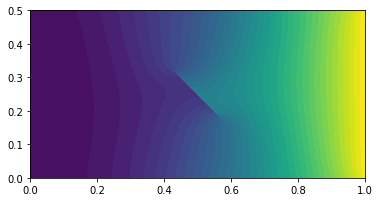

In [ ]:
plot(dot(u,u))


In [ ]:
# damage problem
# Bounds

upperbound = project(Constant(1.), V_alpha)
lowerbound = project(Constant(0.), V_alpha)

# Boundary conditions
# set damage = 0 where we impose displacement boundary conditions

bc_a1 = DirichletBC(V_alpha, Constant(0.), left)
bc_a2 = DirichletBC(V_alpha, Constant(0.), right)

bc_a = [bc_a1, bc_a2]

# Nonlinear problem and solver

problem_alpha = NonlinearVariationalProblem(E_alpha, alpha, bc_a, J=E_alpha_alpha)
problem_alpha.set_bounds(lowerbound, upperbound)

# solver able to solve with bounds: SNES

solver_alpha = NonlinearVariationalSolver(problem_alpha)
# info(solver_alpha.parameters, True)

snes_solver_parameters_bounds = {"nonlinear_solver": "snes", 
                                 "snes_solver": {"maximum_iterations": 300,
                                                 "absolute_tolerance": 1e-10,
                                                 "relative_tolerance": 1e-5,
                                                 "solution_tolerance": 1e-5,
                                                 "report": True,
                                                 "linear_solver" : "mumps"
                                 }
}

# Solver method  |  Description                                                 
# ------------------------------------------------------------------------------
# bicgstab       |  Biconjugate gradient stabilized method                      
# cg             |  Conjugate gradient method                                   
# default        |  default linear solver                                       
# gmres          |  Generalized minimal residual method                         
# minres         |  Minimal residual method                                     
# mumps          |  MUMPS (MUltifrontal Massively Parallel Sparse direct Solver)
# petsc          |  PETSc built in LU solver                                    
# richardson     |  Richardson method                                           
# superlu        |  SuperLU                                                     
# tfqmr          |  Transpose-free quasi-minimal residual method                
# umfpack        |  UMFPACK (Unsymmetric MultiFrontal sparse LU factorization)  

solver_alpha.parameters.update(snes_solver_parameters_bounds)

solver_alpha.solve()

(0, True)

In [ ]:
def alternate_minimisation(alpha, u,
                           alpha_0 = project(Constant(0.), V_alpha),
                           tol=1e-5, maxiter=100):
  alpha_diff = Function(V_alpha)
  iter = 1; error = 1
  alpha.vector()[:] = alpha_0.vector()
  
  while iter < maxiter and error > tol:
    solver_u.solve()
    # u: solution

    solver_alpha.solve()
    # alpha: solution
    # alpha0: alpha at previous timestep

    alpha_diff.vector()[:] = alpha.vector() - alpha_0.vector()
    error = norm(alpha_diff.vector(), 'l2')
    print("Iteration %d, error %e, alpha_max=%.3f"%(iter, error, max(alpha.vector())))
    alpha_0.assign(alpha)

    iter = iter+1

  return (iter, error)

In [ ]:
solver_alpha.solve()

(0, True)

In [ ]:
# alpha = Function(V_alpha)
u_R.t = 1.05
alternate_minimisation(alpha, u)

Iteration 1, error 3.293538e-02, alpha_max=0.008
Iteration 2, error 8.176987e-04, alpha_max=0.008
Iteration 3, error 2.135238e-05, alpha_max=0.008
Iteration 4, error 5.625128e-07, alpha_max=0.008


(5, 5.62512772836811e-07)

In [ ]:
# boundaries
right = CompiledSubDomain("near(x[1], {}, 1e-4)".format(L))
left = CompiledSubDomain("near(x[1], 0, 1e-4)"

right = CompiledSubDomain("near(x[0], {}, 1e-4)".format(Lx/2.))

boundaries = MeshFunction("size_t", mesh, 1)
boundaries.set_all(0)
top.mark(boundaries, 1) # mark top as 1
bottom.mark(boundaries, 2) # mark bottom as 2
right.mark(boundaries, 3) # mark right as 3
ds = Measure("ds",subdomain_data=boundaries) # top: ds(1), bottom: ds(2), right



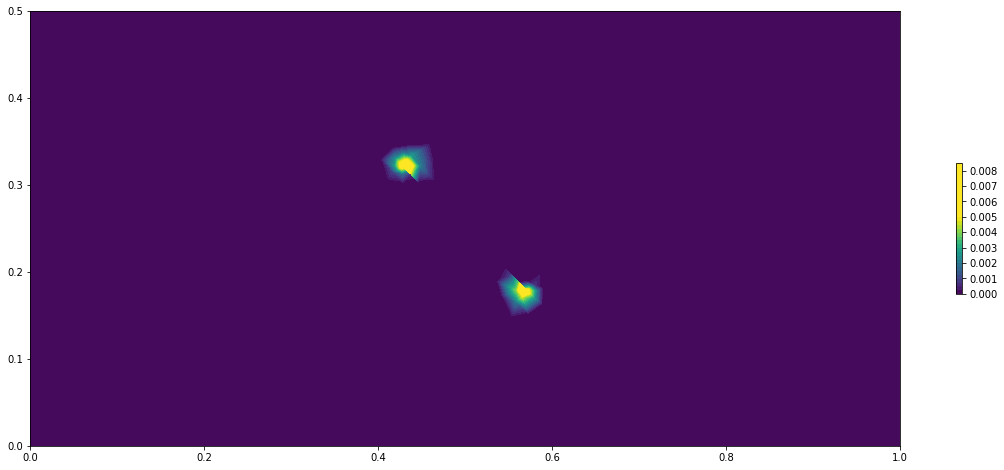

In [ ]:
plt.figure(figsize=(20, 8))
plt.colorbar(plot(alpha, vmin= 0, vmax=0.005), shrink=.3)

In [ ]:
# Evolution monotonically increasing load

loads = np.linspace(.0, 1.5, 30)

energies = []

tot_en = []
sur_en = []
ela_en = []

for (i, t) in enumerate(loads):
  u_R.t = t
  print("** load step: t=%.2f"%t)
  alternate_minimisation(alpha, u, maxiter=200)
  lowerbound.vector()[:] = alpha.vector()
  # postproc
  tot_en.append(assemble(total_energy))
  sur_en.append(assemble(dissipated_energy))
  ela_en.append(assemble(elastic_energy))
  print("** elastic = {:.3f}, surface = {:.3f}, total = {:.3f}".format(ela_en[-1], sur_en[-1], tot_en[-1]))


energies = {'elastic': ela_en, 'surface': sur_en, 'total': tot_en}

** load step: t=0.00
Iteration 1, error 8.855422e+00, alpha_max=0.044
Iteration 2, error 9.864043e-08, alpha_max=0.044
** elastic = 0.000, surface = 0.001, total = 0.001
** load step: t=0.05
Iteration 1, error 0.000000e+00, alpha_max=0.044
** elastic = 0.001, surface = 0.001, total = 0.002
** load step: t=0.10
Iteration 1, error 0.000000e+00, alpha_max=0.044
** elastic = 0.003, surface = 0.001, total = 0.004
** load step: t=0.16
Iteration 1, error 0.000000e+00, alpha_max=0.044
** elastic = 0.006, surface = 0.001, total = 0.007
** load step: t=0.21
Iteration 1, error 0.000000e+00, alpha_max=0.044
** elastic = 0.010, surface = 0.001, total = 0.011
** load step: t=0.26
Iteration 1, error 0.000000e+00, alpha_max=0.044
** elastic = 0.016, surface = 0.001, total = 0.017
** load step: t=0.31
Iteration 1, error 0.000000e+00, alpha_max=0.044
** elastic = 0.023, surface = 0.001, total = 0.024
** load step: t=0.36
Iteration 1, error 0.000000e+00, alpha_max=0.044
** elastic = 0.031, surface = 0.00

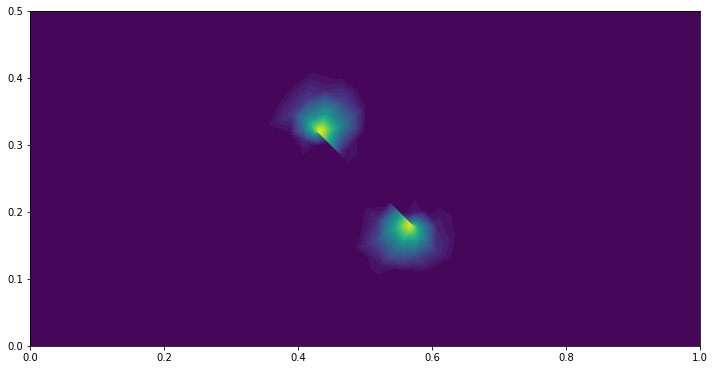

In [ ]:
plt.figure(figsize=(12, 8))
plot(alpha)

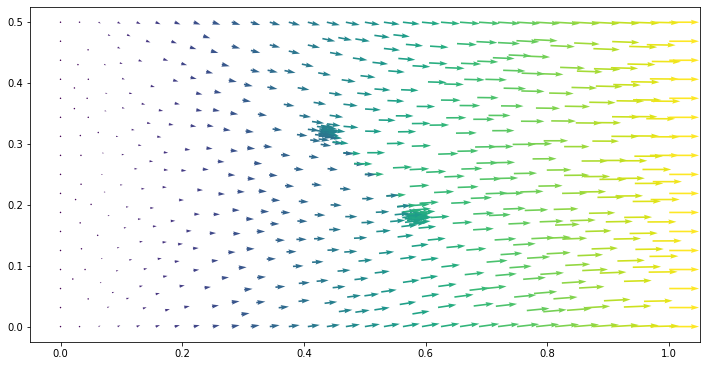

In [ ]:
plt.figure(figsize=(12, 8))
plot(u)

Text(0.5, 0, 't')

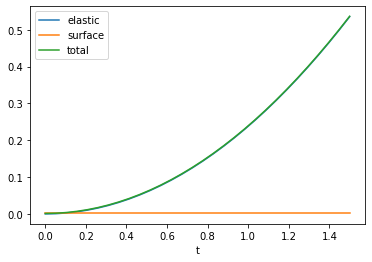

In [ ]:
import sympy
plt.plot(loads, energies['elastic'], label = 'elastic')
plt.plot(loads, energies['surface'], label = 'surface')
plt.plot(loads, energies['total'], label = 'total')
plt.legend()
plt.xlabel('t')
# plt.ylabel('Energies')
#tc = sympy.sqrt(2*(sympy.diff(w(s),s)/sympy.diff(1/a(s),s)).subs({"s":0})/E)

#plt.xticks([0., tc], labels = ['0', '$t_c$'])